<!--<badge>--><a href="https://colab.research.google.com/github/huggingface/workshops/blob/main/europython-2022/02-text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Fine-tuning your first Transformer!

In this notebook we'll take a look at fine-tuning a Transformer model called [DeBERTa](https://huggingface.co/microsoft/deberta-base) for text classification. By the end of this notebook you should know how to:

* Load and process a dataset from the Hugging Face Hub
* Create a baseline with the zero-shot classification pipeline
* Fine-tune and evaluate pretrained model on your data
* Push a model to the Hugging Face Hub

Let's get started!

## Setup

If you're running this notebook on Google Colab or locally, you'll need a few dependencies installed. You can install them with `pip` as follows:

In [1]:
#! pip install datasets transformers sentencepiece

Then you need to install Git-LFS. Uncomment and execute the following cell:

In [2]:
# !apt install git-lfs

## The dataset

In this notebook we'll be using the 🤗 Datasets to load and preprocess our data. If you're new to this library, check out the video below to get some additional context:

In this tutorial we'll use the [IMDB Review Dataset](https://huggingface.co/datasets/imdb). This is a classic dataset of reviews from the IMDB, which we must classify as being either positive or negative.

We can download the dataset from the Hugging Face Hub with the 🤗 Datasets library:

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")
dataset

Reusing dataset imdb (/home/matt/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Like a lot of machine learning datasets, this dataset is a `DatasetDict` split into a big 'train' chunk and a smaller 'test' chunk. The test chunks exist so we can test the accuracy of our model on data that it hasn't seen before, to make sure it isn't just memorizing our data without learning anything!

Let's take a deeper look at the data we're training on. We can access one of the splits like a standard dictionary.

In [4]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

We can see that `dataset["train"]` is a `Dataset` object, which has two further keys. Let's peek at the first element to see what's going on in there.

In [5]:
# View the first element
dataset['train'][0]

{'text': "All of those who voted less than 5 are obviously not fans of clean, tongue-in-cheek humor. Keaton is brilliant in this - as in most of his work. This is not a blockbuster, bigger-than-life affair. This is campy, slapstick humor played out by some of Hollywood's best (and very versatile) actors. Piscopo was equally on the mark as the top dog wannabee, once.<br /><br />If you want to see the funniest attempt at not really cussing ever filmed, you gotta see Dimitri do his piece as Morone.<br /><br />I gave it a 7.",
 'label': 1}

This looks like a positive review to me! Let's look at a few more to get a feel for this data. We can access several rows with a slice:

In [6]:
dataset["train"][:3]

{'text': ["All of those who voted less than 5 are obviously not fans of clean, tongue-in-cheek humor. Keaton is brilliant in this - as in most of his work. This is not a blockbuster, bigger-than-life affair. This is campy, slapstick humor played out by some of Hollywood's best (and very versatile) actors. Piscopo was equally on the mark as the top dog wannabee, once.<br /><br />If you want to see the funniest attempt at not really cussing ever filmed, you gotta see Dimitri do his piece as Morone.<br /><br />I gave it a 7.",
  'Being an Austrian myself this has been a straight knock in my face. Fortunately I don\'t live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opini

Note that all of these have the same label! Let's see if we can find one that doesn't have that label.

In [7]:
dataset["train"]["label"][:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Hmm. Looks like this dataset isn't in random order. Let's look at the **last** review instead.

In [8]:
dataset["train"][-1]

{'text': 'Why is it that any film about Cleopatra, the last phaoroh brings out the worst in movie making? Whatever attraction the woman had for the greatest Roman of them all, Julius Ceasar, and his successor, Mark Anthony, never seems to come across on the screen as other than the antics of over sexed high school seniors. Despite lavish sets and costumes, this movie is as bad as any Italian "sandals and toga" extravaganza of the 50\'s. Admittedly, this kind of spectacular belongs on the big screen, which is why "Gladiator" went over well, but "Gladiator" did not have all the romance novel sex.<br /><br />Miss Varela has as little acting talent as Elizabeth Taylor, but Timothy Dalton has talent to spare. Pity some of it didn\'t wash off on the others.',
 'label': 0}

So now we can see that a label of 0 means a negative review, and a label of 1 means a positive review. Let's pull out the data into lists:

In [9]:
texts = dataset["train"]["text"]
labels = dataset["train"]["label"]

Note that our data is now just a list of strings and a list of ints. You can take this notebook home and replace these with your own data to train a model to do whatever you like! Note that labels should always be ints starting from 0, so if your task has three categories, for example, then your labels should be 0, 1 and 2.

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called _tokenization_. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors. 

For more information about tokenizers, check out the following video:

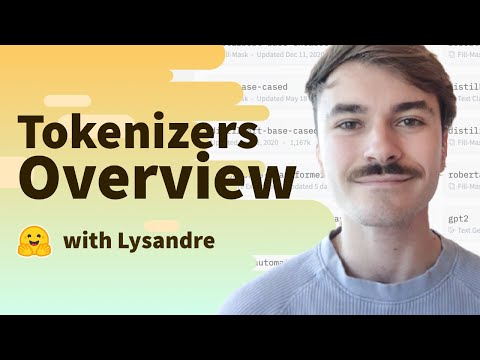

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("VFp38yj8h3A", width=600, height=400)

We will want to start with a pretrained model, and pretrained models always come with their own tokenizers, so to get started let's download the tokenizer of `DeBERTa` from the Hub. `DeBERTa` has an unusual tokenizer, so we need to set `use_fast=False` here to skip our more optimized tokenization algorithms. For most models, you don't need to worry about this detail, and tokenization should be quite quick for our data anyway.

In [11]:
from transformers import AutoTokenizer

model_checkpoint = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/matt/PycharmProjects/transformers/src/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The tokenizer has a few interesting attributes such as the vocabulary size:

In [12]:
tokenizer.vocab_size

128000

This tells us that DeBERTa has 128,000 tokens that is can use to represent text with. Some of the tokens are called _special tokens_ to indicate whether a token is the start or end of a sentence, or corresponds to the mask that is associated with language modeling. Here's what the special tokens look like for DeBERTa:

In [13]:
tokenizer.special_tokens_map

{'bos_token': '[CLS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [14]:
encoded_str = tokenizer("Today I'm giving an NLP workshop at EuroPython")
encoded_str

{'input_ids': [1, 1715, 273, 280, 358, 1175, 299, 40903, 3956, 288, 7303, 65724, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

and then decode the input IDs to see the mapping explicitly:

In [15]:
for token in encoded_str["input_ids"]:
    print(token, tokenizer.decode([token]))

1 [CLS]
1715 Today
273 I
280 '
358 m
1175 giving
299 an
40903 NLP
3956 workshop
288 at
7303 Euro
65724 Python
2 [SEP]


So to prepare our inputs, we simply need to apply the tokenizer to each example in our corpus. Thankfully, our tokenizers are smart, and will handle a list of strings properly!

In [16]:
tokenized_inputs = tokenizer(texts, 
                             padding="longest", 
                             truncation=True, 
                             max_length=256, 
                             return_tensors="np")

What's "np", and why did we use it? This is a good time for a...

### Very Brief Introduction to NumPy

Numpy is a fantastic Python library for storing and working with **big numerical data**. To see how it works, let's take a look at the data we got from our tokenizer.

In [17]:
tokenized_inputs

{'input_ids': array([[    1,   545,   265, ...,     0,     0,     0],
       [    1,  3555,   299, ...,   348, 15383,     2],
       [    1,  2060, 83616, ...,     0,     0,     0],
       ...,
       [    1,  1369,   261, ...,   555,  4829,     2],
       [    1,   273,  1298, ...,     0,     0,     0],
       [    1,  1167,   269, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

This looks like a dictionary, but watch out, it isn't! If we use this as a dictionary downstream we might get errors, so let's convert it now before we forget:

In [18]:
tokenized_inputs = dict(tokenized_inputs)

The "input_ids" are the tokens we want. Let's take a look at them:

In [19]:
input_ids = tokenized_inputs["input_ids"]
input_ids

array([[    1,   545,   265, ...,     0,     0,     0],
       [    1,  3555,   299, ...,   348, 15383,     2],
       [    1,  2060, 83616, ...,     0,     0,     0],
       ...,
       [    1,  1369,   261, ...,   555,  4829,     2],
       [    1,   273,  1298, ...,     0,     0,     0],
       [    1,  1167,   269, ...,     0,     0,     0]])

This is **all of our data, after being tokenized**. You can think of it like a list of lists, but it has a number of cool features:

In [20]:
# Index or slice just like a list
input_ids[3]

array([     1,    486,    266,  11490,   2908,    322,    275,  77281,
        15123,  18686,    287,    452,  11060,    265,  81381,  23344,
        18686,    285,    261,    543,    260,    430,    260,   2384,
         1516,   1562,   1658,   1011,    260,   3838,  10107,    287,
        36249,  44602,  10784,    285,   1587,  38890,    268,    837,
         2462,    313,   2212,    284,    941,    262,    665,    260,
         3289,    261,    262,  11490,    519,    272,    384,    293,
          411,  11126,    261,    263,    343,    280,    268,    266,
          397,   1177,    272,    262,  24979,    296,    564,   8514,
          262,  18686,    261,   1249,    264,    299,  13912,    260,
         5668,   2318,   5854,   2790,   7622,    287,  20218,   7906,
          285,    261,    328,    269,  19615,    264,   1362,    444,
          262,  24979,    283,    950,    283,    628,    263,  35248,
          266,    628,   1200,   5069,    260,   4052,   8981,    840,
      

In [21]:
# Index columns instead of rows!
input_ids[:, 0]

array([1, 1, 1, ..., 1, 1, 1])

In [22]:
# You can cut squares out of it by slicing both dimensions at once
input_ids[1:3, 2:4]

array([[  299, 14608],
       [83616,   269]])

In [23]:
# You can even do maths with the arrays (but don't do this to tokens!)
input_ids + 5

array([[    6,   550,   270, ...,     5,     5,     5],
       [    6,  3560,   304, ...,   353, 15388,     7],
       [    6,  2065, 83621, ...,     5,     5,     5],
       ...,
       [    6,  1374,   266, ...,   560,  4834,     7],
       [    6,   278,  1303, ...,     5,     5,     5],
       [    6,  1172,   274, ...,     5,     5,     5]])

In [24]:
# Arrays come with helpful metadata
input_ids.shape

(25000, 256)

We have 25000 samples, and a maximum length of 256 tokens. This looks good!

Before we finish, let's convert our list of labels into a NumPy array:

In [25]:
import numpy as np

labels = np.array(labels)
labels

array([1, 1, 1, ..., 0, 0, 0])

Finally, let's convert our test data the same way as we did our training data.

In [26]:
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]
tokenized_test = tokenizer(test_texts, 
                           padding="longest", 
                           truncation=True, 
                           max_length=256, 
                           return_tensors="np")
tokenized_test = dict(tokenized_test)
test_labels = np.array(test_labels)

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `TFAutoModelForXxx` class and use the `from_pretrained()` function. All we need to initialize our model now is to give it a model checkpoint and the number of labels in our problem, which is 2. Remember to use the same checkpoint you loaded your tokenizer from, or the model will get very confused and probably crash! We can also set the `id2label` property here, which tells the model the names of the categories the labels correspond to. This is optional, but will make the output a little cleaner later.

In [27]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label={0: "Negative", 1: "Positive"}
)

2022-07-08 17:28:25.899275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 17:28:25.906208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 17:28:25.907248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 17:28:25.908725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

These warnings are perfectly normal - they are telling us that the weights in the head of the network are randomly initialised and so we should fine-tune the model on a downstream task.

Now that we have a model, we need to set an optimizer. We'll use `Adam` - this is sort of the 'default' optimizer for deep learning that everyone uses these days.

In [28]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(2e-5)

That `2e-5` is the "learning rate". It represents how quickly the model updates its neuron connection 'weights' in response to new data. Setting this value too high can make it very unstable!

Adam(2e-5) will work for training just about any `transformers` model. For other model types, especially ones that don't start from a pre-trained checkpoint, you will probably want a larger learning rate, from 1e-4 to 1e-3.

Now, we 'compile' our model with our optimizer. We can also add a 'metric' here, which will give us more information during training. In normal TensorFlow code we would also add a loss function, but `transformers` models will choose one automatically for us. We can, of course, override the default loss if we want to!

In [29]:
model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Now is the time to cross our fingers very hard, because we're going to...

## Train our model

Since we're using Keras, this will be surprisingly easy:

In [30]:
model.fit(tokenized_inputs, labels, batch_size=8, shuffle=True, epochs=2, validation_data=(tokenized_test, test_labels))

Epoch 1/2
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
3125/3125 [==============================] - 747s 232ms/step - loss: 0.2575 - accuracy: 0.8879 - val_loss: 0.1957 - val_accuracy: 0.9338
Epoch 2/2
3125/3125 [==============================] - 732s 234ms/step - loss: 0.1467 - accuracy: 0.9475 - val_loss: 0.1652 - val_accuracy: 0.9353


After two epochs of training, we can see our accuracy is in the range of 94-96%, or an error rate of 4-6%. These are the kind of numbers that you could publish [a major research paper](https://arxiv.org/abs/1801.06146) on in 2018, and now you can get them with 30-40 lines of Python in a single notebook. If you take a bit more time to tweak things like your learning rate and number of epochs, and maybe use some advanced tricks like weight decay and a learning rate schedule (see the [Hugging Face Course](https://huggingface.co/course/chapter3/1?fw=tf)!) you can do even better.

## Sharing our model

After training, we can also push our model to the hub. To do this, you'll need to register a HuggingFace account. Once you have an account, you can get a token from your [access tokens page](https://huggingface.co/settings/tokens). Don't panic if you don't want to, though - you don't need an account to load existing models, so you can continue on without an account if you prefer!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("europython-imdb")

In [ ]:
tokenizer.push_to_hub("europython-imdb")

Once we upload our model from the hub, we can load it with `from_pretrained()` just like we loaded our base model at the start of this notebook! If you found training above was too slow for you, you can use this command to load one I pre-trained earlier, and continue on with the notebook from here.

In [31]:
model = TFAutoModelForSequenceClassification.from_pretrained("Rocketknight1/europython-imdb")

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

All the layers of TFDebertaV2ForSequenceClassification were initialized from the model checkpoint at Rocketknight1/europython-imdb.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.


## Using your fine-tuned model

In [32]:
from transformers import pipeline 

classifier = pipeline("text-classification", model="Rocketknight1/europython-imdb", use_fast=False)

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

All the layers of TFDebertaV2ForSequenceClassification were initialized from the model checkpoint at Rocketknight1/europython-imdb.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.


In [33]:
classifier("I really wanted to like the Hunger Games, but even though there were a lot of great aspects, as a whole the movie just didn't really work!")

[{'label': 'Negative', 'score': 0.9846228957176208}]

And that's it! We started with a general language model, loaded some reviews and labels, and fine-tuned the model to classify the sentiment in those reviews.

The critical thing to notice here is that this same technique applies to **any** task involving classifying text. All you have to do is swap in different texts and different labels, run the training code again, and you get a model that can do a completely different task. You aren't even limited to English text - base models exist for many languages, and there are even several multilingual models! Remember that the `use_fast=False` bit is specific to DeBERTa, so you probably don't need it for other models. Check out the [HuggingFace Hub](https://huggingface.co/models) if you want to see a list of them.